In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, datetime
import tensorflow as tf
import json
import math

AUTOTUNE = tf.data.AUTOTUNE
from sklearn import preprocessing

class PreprocessorML():
    def __init__(self, normalization=False):
        self.norm = normalization
    

    def one_hot_category(self, dataset):
        hot = ['gas_transport', 'grocery_pos', 'home', 'shopping_pos', 'kids_pets', 'shopping_net', 'entertainment',
               'food_dining', 'personal_care', 'health_fitness', 'misc_pos', 'misc_net', 'grocery_net', 'travel']
        
        for category in hot:
            dataset[category] = pd.Series([1 if x.category == category else 0 for x in dataset.itertuples()],
                                          index=dataset.index)
        
        return dataset


    def add_time(self, dataset):
        dataframe = dataset.sort_values(by=['cc_num', 'unix_time'])

        delta_time = []

        previous_row = dataframe.iloc[0]

        delta_time.append(0)

        for row in dataframe[1:].itertuples():

            if row.cc_num == previous_row.cc_num:
                delta_time.append(row.unix_time - previous_row.unix_time)
            else:
                delta_time.append(0)

            previous_row = row

        dataframe['delta_time'] = pd.Series(delta_time, index=dataframe.index)

        return dataframe


    def parse_time(self, string):
        return datetime.strptime(string, "%Y-%m-%d %H:%M:%S")


    def add_workhour_category(self, dataset):
        dataset['work_hours'] = dataset['trans_date_trans_time'].apply(
            lambda x: 
                int(self.parse_time(x).hour >= 6 and self.parse_time(x).hour <= 18))
        return dataset


    def add_weekend_category(self, dataset):
        dataset['weekend'] = dataset['trans_date_trans_time'].apply(
            lambda x: 
                int(self.parse_time(x).weekday() >= 5 and self.parse_time(x).weekday() <= 6))
        return dataset

    
    def add_age(self, dataset):
        dataset['age'] = dataset['dob'].apply(lambda x: (date.today() - date.fromisoformat(x)).days // 365)
        return dataset


    def add_distance(self, dataset):
        lat1 = dataset['lat']
        lon1 = dataset['longs']
        lat2 = dataset['merch_lat']
        lon2 = dataset['merch_long']
        dataset['distance'] = np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2)) * 6371
        return dataset

    
    def add_gender(self, dataset):
        dataset['gender'] = pd.Categorical(dataset['gender'], categories=['F', 'M'])
        hot = pd.get_dummies(dataset['gender'], columns = ['F', 'M'])
        
        return dataset.join(hot)


    def add_weekday(self, dataset):
        dataset['weekday'] = dataset['trans_date_trans_time'].apply(
            lambda x: int(self.parse_time(x).weekday()))
        
        return dataset
    
    def add_hour(self, dataset):
        dataset['hour'] = dataset['trans_date_trans_time'].apply(
            lambda x: int(self.parse_time(x).hour))
        
        return dataset


    def preprocess(self, dataset, columns_to_delete):
        dataset = self.add_age(dataset)
        dataset = self.add_time(dataset)
        dataset = self.add_distance(dataset)
        dataset = self.one_hot_category(dataset)
        print(dataset.columns)
        dataset = self.add_workhour_category(dataset)
        dataset = self.add_weekend_category(dataset)
        dataset = self.add_gender(dataset)
        dataset = self.add_hour(dataset)
        dataset = self.add_weekday(dataset)

        dataset = dataset.drop(columns_to_delete, axis = 1)

        return dataset

class DataLoader():
    def __init__(self, batch_size=32, max_transactions=32):
        self.batch_size = batch_size
        self.max_transactions = max_transactions


    def add_padding_example(self, example):
        len(example[0])
        padding_ = [0 for x in example[0]]

        while len(example) < self.max_transactions:
            example.append(padding_)
            
        return example


    def add_padding_label(self, label):
        padding_ = 2

        while len(label) < self.max_transactions:
            label.append(padding_)
            
        return label
    

    def divide_to_examples(self, dataset):
        examples = []
        labels = []

        c_user = 0
        l_users = len(dataset.groupby('cc_num'))

        for user_transactions in dataset.groupby('cc_num'):

            user_df = user_transactions[1]

            counter = 0
            while user_df.iloc[counter: counter + self.max_transactions].shape[0] != 0:
                current_example = user_df.iloc[counter: counter + self.max_transactions].copy().drop(['cc_num', 'is_fraud'], axis=1)

                is_fraud = list(user_df.iloc[counter: counter + self.max_transactions]['is_fraud'])

                array = current_example.to_numpy().tolist()

                self.add_padding_example(array)
                self.add_padding_label(is_fraud)

                labels.append(is_fraud)
                examples.append(array)
            
                counter += 1
            
            c_user += 1

            if c_user % 1000 == 0:
                print('Dataset processed: ', c_user / l_users, '%')


        return np.asarray(examples), np.asarray(labels)


    def normalize_dataset(self, dataset, columns, norm='euclid', params_path=None, save=False):
        save_params = {}
        loaded_params = None
        if params_path!=None:
            f = open(params_path)
            loaded_params = json.load(f)
            f.close()

        for column in columns:
            if norm == 'euclid':
                dataset[column] = preprocessing.normalize([dataset[column]])[0]
            elif norm == 'gauss':
                vector = tf.constant([list(dataset[column])], dtype=tf.float32)
                if loaded_params != None and column in loaded_params:
                    mean = loaded_params[column]['mean']
                    variance = loaded_params[column]['variance']
                else:
                    mean = tf.math.reduce_mean(vector, axis=1)
                    variance = tf.math.reduce_variance(vector, axis=1)[0]

                dataset[column] = dataset[column].apply(lambda x: (x - float(mean)) / math.sqrt(float(variance)))

                config_dict = {'mean': float(mean), 'variance': float(variance)}
                save_params[column] = config_dict
        if  save:       
            file = open('dataset_config.json', 'w')
            str_obj = json.dumps(save_params)
            file.write(str_obj)
            file.flush()
            file.close()
        return dataset

    
    def process_batch(self, element_x, element_y):
        return {'example':element_x, 'label':element_y}


    def load_dataset(self, path, preprocess=False, columns_to_delete = [ 
                      'city', 
                      'dob', 
                      'job', 
                      'first', 
                      'last',
                      'trans_date_trans_time',
                      'category',
                      'trans_num',
                      'lat',
                      'long',
                      'merch_lat',
                      'merch_long',
                      'unix_time',
                      'street',
                      'merchant',
                      'state',
                      'gender'], to_process='ALL', normalization=['delta_time', 'distance', 'city_pop'], example_weights=None,
                     divide=True, params_path=None, save=False):
        dataset = pd.read_csv(path)
        print(dataset.columns)
        if to_process != 'ALL':
            dataset = dataset[:to_process]
        # Preprocess dataset if preprocess == True
        if preprocess:
            preprocessor = PreprocessorML()
            dataset = preprocessor.preprocess(dataset, columns_to_delete)
        
        if normalization:
            dataset = self.normalize_dataset(dataset, normalization, norm='gauss', params_path=params_path, save=save)
        dataset_X = dataset.drop(['cc_num'], axis = 1).to_numpy().tolist()
        

        dataset = tf.data.Dataset.from_tensor_slices((dataset_X)).batch(self.batch_size).prefetch(AUTOTUNE)
        return dataset

In [3]:
X_ = DataLoader(batch_size = 2048).load_dataset(path='../datasets/fraudTest.csv',
                                 preprocess=True, divide=False, to_process=10000, save=False, params_path='../../dataset_config.json', columns_to_delete = [ 'city', 'dob', 'job',  'first', 'last','trans_date_trans_time','category','trans_num',
                      'lat','longs','merch_lat','merch_long','unix_time','street','merchant','state','zip','gender'], normalization=['amt', 'delta_time', 'distance', 'city_pop', 'age', 'hour', 'weekday'])

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


KeyError: 'longs'

In [ ]:
dat = pd.read_csv('../datasets/fraudTest.csv')

In [ ]:
dat[dat['cc_num'] == 3591919803438423][dat['amt'] == 988.31]

<ipython-input-68-d7d02ef8bebb>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dat[dat['cc_num'] == 3591919803438423][dat['amt'] == 988.31]


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
453937,453937,2020-12-08 23:15:43,3591919803438423,"fraud_Romaguera, Cruickshank and Greenholt",shopping_net,988.31,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,31672226b0a8a2cdcad2fd2350fc3f40,1386544543,28.460745,-81.369518,1


In [ ]:
md2 = tf.keras.models.load_model('model_md_fnn_v3_0.h5')

In [ ]:
md2.predict(X_)

1/1 [==============================] - 4s 4s/step


array([[0.18918838]], dtype=float32)

In [ ]:
dataset = pd.read_csv('../datasets/fraudTrain.csv', index_col=0)

In [ ]:
len(dataset)

32

In [ ]:
dataset.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'longs', 'city_pop', 'job',
       'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long'],
      dtype='object')

In [ ]:
dataset = dataset.rename({'long':'longs'})

In [ ]:
dataset_ = dataset[dataset['category'] == 'misc_net'][dataset['amt'] == 1015.53][dataset['gender'] == 'M']

<ipython-input-251-b820fa7c9826>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_ = dataset[dataset['category'] == 'misc_net'][dataset['amt'] == 1015.53][dataset['gender'] == 'M']


In [ ]:
dataset_.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
457053,2020-12-09 23:19:18,3591919803438423,fraud_Zemlak Group,misc_net,1015.53,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,99759c4c41396188a9fb5498650aa775,1386631158,28.563715,-80.885251,1


In [ ]:
dataset__ = dataset[dataset['category'] == 'shopping_net'][dataset['amt'] == 911.05][dataset['gender'] == 'M']

<ipython-input-238-568c0c69cd64>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset__ = dataset[dataset['category'] == 'shopping_net'][dataset['amt'] == 911.05][dataset['gender'] == 'M']


In [ ]:
dataset__

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
454114,2020-12-08 23:48:10,3591919803438423,"fraud_Altenwerth, Cartwright and Koss",shopping_net,911.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,fa377d0ecf208b0fb11b2d0897271254,1386546490,28.193086,-81.135456,1


In [ ]:
pd.DataFrame(dataset.iloc[31:32]).to_csv('../datasets/fraudTest.csv')

In [ ]:
dataset_.iloc[0]

trans_date_trans_time                     2020-06-27 03:03:17
cc_num                                       3591919803438423
merchant                 fraud_Schaefer, Maggio and Daugherty
category                                        gas_transport
amt                                                      77.0
first                                                   Brian
last                                                 Williams
gender                                                      M
street                            32941 Krystal Mill Apt. 552
city                                               Titusville
state                                                      FL
zip                                                     32780
lat                                                   28.5697
long                                                 -80.8191
city_pop                                                54767
job                                              Set designer
dob     

In [ ]:
class PreprocessorML():
    def __init__(self, normalization=False):
        self.norm = normalization
    

    def one_hot_category(self, dataset):
        hot = ['gas_transport', 'grocery_pos', 'home', 'shopping_pos', 'kids_pets', 'shopping_net', 'entertainment',
               'food_dining', 'personal_care', 'health_fitness', 'misc_pos', 'misc_net', 'grocery_net', 'travel']
        
        for category in hot:
            dataset[category] = pd.Series([1 if x.category == category else 0 for x in dataset.itertuples()],
                                          index=dataset.index)
        
        return dataset


    def add_time(self, dataset):
        dataframe = dataset.sort_values(by=['cc_num', 'unix_time'])

        delta_time = []

        previous_row = dataframe.iloc[0]

        delta_time.append(0)

        for row in dataframe[1:].itertuples():

            if row.cc_num == previous_row.cc_num:
                delta_time.append(row.unix_time - previous_row.unix_time)
            else:
                delta_time.append(0)

            previous_row = row

        dataframe['delta_time'] = pd.Series(delta_time, index=dataframe.index)

        return dataframe


    def parse_time(self, string):
        return datetime.strptime(string, "%Y-%m-%d %H:%M:%S")


    def add_workhour_category(self, dataset):
        dataset['work_hours'] = dataset['trans_date_trans_time'].apply(
            lambda x: 
                int(self.parse_time(x).hour >= 6 and self.parse_time(x).hour <= 18))
        return dataset


    def add_weekend_category(self, dataset):
        dataset['weekend'] = dataset['trans_date_trans_time'].apply(
            lambda x: 
                int(self.parse_time(x).weekday() >= 5 and self.parse_time(x).weekday() <= 6))
        return dataset

    
    def add_age(self, dataset):
        dataset['age'] = dataset['dob'].apply(lambda x: (date.today() - date.fromisoformat(x)).days // 365)
        return dataset


    def add_distance(self, dataset):
        lat1 = dataset['lat']
        lon1 = dataset['longs']
        lat2 = dataset['merch_lat']
        lon2 = dataset['merch_long']
        dataset['distance'] = np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2)) * 6371
        return dataset

    
    def add_gender(self, dataset):
        dataset['gender'] = pd.Categorical(dataset['gender'], categories=['F', 'M'])
        hot = pd.get_dummies(dataset['gender'], columns = ['F', 'M'])
        
        return dataset.join(hot)


    def add_weekday(self, dataset):
        dataset['weekday'] = dataset['trans_date_trans_time'].apply(
            lambda x: int(self.parse_time(x).weekday()))
        
        return dataset
    
    def add_hour(self, dataset):
        dataset['hour'] = dataset['trans_date_trans_time'].apply(
            lambda x: int(self.parse_time(x).hour))
        
        return dataset


    def preprocess(self, dataset, columns_to_delete=['cc_num', 
                      'city', 
                      'dob', 
                      'job', 
                      'first', 
                      'last',
                      'trans_date_trans_time',
                      'category',
                      'trans_num',
                      'lat',
                      'longs',
                      'merch_lat',
                      'merch_long',
                      'unix_time',
                      'street',
                      'merchant',
                      'state',
                      'gender']):
        dataset = self.add_age(dataset)
        dataset = self.add_time(dataset)
        dataset = self.add_distance(dataset)
        dataset = self.one_hot_category(dataset)
        dataset = self.add_workhour_category(dataset)
        dataset = self.add_weekend_category(dataset)
        dataset = self.add_gender(dataset)
        print(type(dataset))
        dataset = self.add_hour(dataset)
        print(type(dataset))
        dataset = self.add_weekday(dataset)
        print(type(dataset))

        dataset = dataset.drop(columns_to_delete, axis = 1)

        return dataset
    
    def preprocess_submit(self, data):
        return self.preprocess(data)


In [ ]:
X = DataLoader(batch_size = 2048).load_dataset(path='../datasets/fraudTest.csv',
                                 preprocess=True, divide=False, to_process=10000, save=False, params_path='../../models/dataset_config.json', columns_to_delete = [ 'city', 'dob', 'job',  'first', 'last','trans_date_trans_time','category','trans_num',
                      'lat','long','merch_lat','merch_long','unix_time','street','merchant','state','zip','gender'], normalization=['amt', 'delta_time', 'distance', 'city_pop', 'age', 'hour', 'weekday'])

      trans_date_trans_time            cc_num  \
16518   2020-06-27 03:03:17  3591919803438423   

                                   merchant       category   amt  first  \
16518  fraud_Schaefer, Maggio and Daugherty  gas_transport  77.0  Brian   

           last gender                       street        city  ...      lat  \
16518  Williams      M  32941 Krystal Mill Apt. 552  Titusville  ...  28.5697   

          long  city_pop           job         dob  \
16518 -80.8191     54767  Set designer  1987-07-25   

                              trans_num   unix_time  merch_lat  merch_long  \
16518  34c6238ee0a06cb8c5dbb10793af1189  1372302197  28.702726   -79.90546   

       is_fraud  
16518         0  

[1 rows x 22 columns]
kdjsklfnsjldfhlsndfjknsjldfjksdbjkfbhsjkhdfjksn
      trans_date_trans_time            cc_num  \
16518   2020-06-27 03:03:17  3591919803438423   

                                   merchant       category   amt  first  \
16518  fraud_Schaefer, Maggio and Daughe

In [ ]:
# -*- coding: utf-8 -*-
"""Preprocessing Ihor Kostiuk.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1UVmNnzYzNQjuO3RU8X-ChyCNzarlPX8E
"""

import pandas as pd
import numpy as np
import datetime
from datetime import date, datetime
import tensorflow as tf
import json
import math

AUTOTUNE = tf.data.AUTOTUNE
from sklearn import preprocessing

class PreprocessorML():
    def __init__(self, normalization=False):
        self.norm = normalization
    

    def one_hot_category(self, dataset):
        hot = ['gas_transport', 'grocery_pos', 'home', 'shopping_pos', 'kids_pets', 'shopping_net', 'entertainment',
               'food_dining', 'personal_care', 'health_fitness', 'misc_pos', 'misc_net', 'grocery_net', 'travel']
        
        for category in hot:
            dataset[category] = pd.Series([1 if x.category == category else 0 for x in dataset.itertuples()],
                                          index=dataset.index)
        
        return dataset


    def add_time(self, dataset):
        dataframe = dataset.sort_values(by=['cc_num', 'unix_time'])

        delta_time = []

        previous_row = dataframe.iloc[0]

        delta_time.append(0)

        for row in dataframe[1:].itertuples():

            if row.cc_num == previous_row.cc_num:
                delta_time.append(row.unix_time - previous_row.unix_time)
            else:
                delta_time.append(0)

            previous_row = row

        dataframe['delta_time'] = pd.Series(delta_time, index=dataframe.index)

        return dataframe


    def parse_time(self, string):
        return datetime.strptime(string, "%Y-%m-%d %H:%M:%S")


    def add_workhour_category(self, dataset):
        dataset['work_hours'] = dataset['trans_date_trans_time'].apply(
            lambda x: 
                int(self.parse_time(x).hour >= 6 and self.parse_time(x).hour <= 18))
        return dataset


    def add_weekend_category(self, dataset):
        dataset['weekend'] = dataset['trans_date_trans_time'].apply(
            lambda x: 
                int(self.parse_time(x).weekday() >= 5 and self.parse_time(x).weekday() <= 6))
        return dataset

    
    def add_age(self, dataset):
        dataset['age'] = dataset['dob'].apply(lambda x: (date.today() - date.fromisoformat(x)).days // 365)
        return dataset


    def add_distance(self, dataset):
        lat1 = dataset['lat']
        lon1 = dataset['longs']
        lat2 = dataset['merch_lat']
        lon2 = dataset['merch_long']
        dataset['distance'] = np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2)) * 6371
        return dataset

    
    def add_gender(self, dataset):
        dataset['gender'] = pd.Categorical(dataset['gender'], categories=['F', 'M'])
        hot = pd.get_dummies(dataset['gender'], columns = ['F', 'M'])
        
        return dataset.join(hot)


    def add_weekday(self, dataset):
        dataset['weekday'] = dataset['trans_date_trans_time'].apply(
            lambda x: int(self.parse_time(x).weekday()))
        
        return dataset
    
    def add_hour(self, dataset):
        dataset['hour'] = dataset['trans_date_trans_time'].apply(
            lambda x: int(self.parse_time(x).hour))
        
        return dataset


    def preprocess(self, dataset, columns_to_delete=['cc_num', 
                      'city', 
                      'dob', 
                      'job', 
                      'first', 
                      'last',
                      'trans_date_trans_time',
                      'category',
                      'trans_num',
                      'lat',
                      'longs',
                      'merch_lat',
                      'merch_long',
                      'unix_time',
                      'street',
                      'merchant',
                      'state',
                      'gender']):
        print(dataset.columns)
        dataset = self.add_age(dataset)
        dataset = self.add_time(dataset)
        dataset = self.add_distance(dataset)
        dataset = self.one_hot_category(dataset)
        dataset = self.add_workhour_category(dataset)
        dataset = self.add_weekend_category(dataset)
        dataset = self.add_gender(dataset)
        print(type(dataset))
        dataset = self.add_hour(dataset)
        print(type(dataset))
        dataset = self.add_weekday(dataset)
        print(type(dataset))

        dataset = dataset.drop(columns_to_delete, axis = 1)

        return dataset

class DataLoader():
    def __init__(self, batch_size=32, max_transactions=32):
        self.batch_size = batch_size
        self.max_transactions = max_transactions


    def add_padding_example(self, example):
        len(example[0])
        padding_ = [0 for x in example[0]]

        while len(example) < self.max_transactions:
            example.append(padding_)
            
        return example


    def add_padding_label(self, label):
        padding_ = 2

        while len(label) < self.max_transactions:
            label.append(padding_)
            
        return label
    

    def divide_to_examples(self, dataset):
        examples = []
        labels = []

        c_user = 0
        l_users = len(dataset.groupby('cc_num'))

        for user_transactions in dataset.groupby('cc_num'):

            user_df = user_transactions[1]

            counter = 0
            while user_df.iloc[counter: counter + self.max_transactions].shape[0] != 0:
                current_example = user_df.iloc[counter: counter + self.max_transactions].copy().drop(['cc_num', 'is_fraud'], axis=1)

                is_fraud = list(user_df.iloc[counter: counter + self.max_transactions]['is_fraud'])

                array = current_example.to_numpy().tolist()

                self.add_padding_example(array)
                self.add_padding_label(is_fraud)

                labels.append(is_fraud)
                examples.append(array)
            
                counter += 1
            
            c_user += 1

            if c_user % 1000 == 0:
                print('Dataset processed: ', c_user / l_users, '%')


        return np.asarray(examples), np.asarray(labels)


    def normalize_dataset(self, dataset, columns, norm='euclid'):
        for column in columns:
            if norm == 'euclid':
                dataset[column] = preprocessing.normalize([dataset[column]])[0]
            elif norm == 'gauss':
                vector = tf.constant([list(dataset[column])], dtype=tf.float32)
                mean = tf.math.reduce_mean(vector, axis=1)
                variance = tf.math.reduce_variance(vector, axis=1)[0]

                dataset[column] = dataset[column].apply(lambda x: (x - float(mean)) / math.sqrt(float(variance)))

                file = open('dataset_config.json', 'w')
                config_dict = {'mean': float(mean), 'variance': float(variance)}
                str_obj = json.dumps(config_dict)
                file.write(str_obj)
                file.flush()
                file.close()

        return dataset

    
    def process_batch(self, element_x, element_y):
        return {'example':element_x, 'label':element_y}


    def load_dataset(self, path, preprocess=False, columns_to_delete = [ 
                      'city', 
                      'dob', 
                      'job', 
                      'first', 
                      'last',
                      'trans_date_trans_time',
                      'category',
                      'trans_num',
                      'lat',
                      'long',
                      'merch_lat',
                      'merch_long',
                      'unix_time',
                      'street',
                      'merchant',
                      'state',
                      'gender'], to_process='ALL', normalization=['delta_time', 'distance', 'city_pop'], example_weights=None,
                     divide=True):
        dataset = pd.read_csv(path, index_col=0)
        if to_process != 'ALL':
            dataset = dataset[:to_process]

        # Preprocess dataset if preprocess == True
        if preprocess:
            preprocessor = PreprocessorML()
            dataset = preprocessor.preprocess(dataset, columns_to_delete)
        
        if normalization:
            dataset = self.normalize_dataset(dataset, normalization, norm='gauss')

        dataset_X, dataset_y = None, None
        if divide:
            dataset_X, dataset_y = self.divide_to_examples(dataset)
        else:
            dataset_X, dataset_y = dataset.drop(['is_fraud', 'cc_num'], axis = 1).to_numpy().tolist(), list(dataset['is_fraud'])
        

        dataset = tf.data.Dataset.from_tensor_slices((dataset_X, dataset_y))

        return dataset.batch(self.batch_size).prefetch(AUTOTUNE)



In [ ]:
X = DataLoader(batch_size = 2048).load_dataset(path='../datasets/fraudTrain.csv',
                                 preprocess=True, divide=False, to_process=10000, params_path='../../models/dataset_config.json', columns_to_delete = [ 'city', 'dob', 'job',  'first', 'last','trans_date_trans_time','category','trans_num',
                      'lat','long','merch_lat','merch_long','unix_time','street','merchant','state','zip','gender'], normalization=['amt', 'delta_time', 'distance', 'city_pop', 'age', 'hour', 'weekday'])

TypeError: ignored

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
len(X)

634

In [ ]:
next(iter(X))

(<tf.Tensor: shape=(2048, 25), dtype=float32, numpy=
 array([[-0.39347944, -0.28871545, -0.689863  , ...,  0.        ,
         -0.11805211, -0.94197476],
        [-0.1086045 , -0.28871545, -0.689863  , ...,  0.        ,
         -0.70474976, -0.48704717],
        [ 0.07316154, -0.28871545, -0.689863  , ...,  0.        ,
         -0.70474976, -0.48704717],
        ...,
        [ 0.2400819 , -0.13869704,  1.8370826 , ...,  1.        ,
         -1.2914475 ,  0.87773573],
        [-0.40595478, -0.13869704,  1.8370826 , ...,  1.        ,
         -0.8514242 ,  0.87773573],
        [-0.2434008 , -0.13869704,  1.8370826 , ...,  1.        ,
          0.17529672,  0.87773573]], dtype=float32)>,
 <tf.Tensor: shape=(2048,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)

In [ ]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(X, len(X))

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  input = keras.layers.Input(name='example', shape=(25,))
  x = keras.layers.Dense(256, activation='relu')(input)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(256, activation='relu')(x)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  x = keras.layers.Dropout(0.1)(x)
  output = keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.models.Model(
        inputs=input, outputs=output, name="handwriting_recognizer"
    )                                             

  model.compile(
      loss=keras.losses.BinaryCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=metrics)

  return model

In [ ]:
model = make_model()
model.summary()

Model: "handwriting_recognizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 example (InputLayer)        [(None, 25)]              0         
                                                                 
 dense_9 (Dense)             (None, 256)               6656      
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)    

In [ ]:
class_weight = {0: 0.5, 1:1}

In [ ]:
model.load_weights('model_md_fnn_v2_2.h5')

In [ ]:
model.fit(train_ds, epochs=200, validation_data=val_ds, class_weight=class_weight)

Epoch 1/200
507/507 [==============================] - 8s 8ms/step - loss: 0.0215 - tp: 1371.0000 - fp: 541.0000 - tn: 1029988.0000 - fn: 4679.0000 - accuracy: 0.9950 - precision: 0.7171 - recall: 0.2266 - auc: 0.8763 - prc: 0.3330 - val_loss: 0.0197 - val_tp: 455.0000 - val_fp: 129.0000 - val_tn: 126408.0000 - val_fn: 275.0000 - val_accuracy: 0.9968 - val_precision: 0.7791 - val_recall: 0.6233 - val_auc: 0.9546 - val_prc: 0.6823
Epoch 2/200
507/507 [==============================] - 3s 7ms/step - loss: 0.0115 - tp: 3760.0000 - fp: 920.0000 - tn: 1029640.0000 - fn: 2259.0000 - accuracy: 0.9969 - precision: 0.8034 - recall: 0.6247 - auc: 0.9441 - prc: 0.6938 - val_loss: 0.0116 - val_tp: 432.0000 - val_fp: 81.0000 - val_tn: 126481.0000 - val_fn: 273.0000 - val_accuracy: 0.9972 - val_precision: 0.8421 - val_recall: 0.6128 - val_auc: 0.9387 - val_prc: 0.7277
Epoch 3/200
507/507 [==============================] - 4s 7ms/step - loss: 0.0086 - tp: 4268.0000 - fp: 920.0000 - tn: 1029668.0000 -

KeyboardInterrupt: ignored

In [ ]:
model.fit(train_ds, epochs=60, validation_data=val_ds, class_weight=class_weight)

Epoch 1/60
507/507 [==============================] - 12s 11ms/step - loss: 0.0104 - tp: 4984.0000 - fp: 537.0000 - tn: 1029997.0000 - fn: 1061.0000 - accuracy: 0.9985 - precision: 0.9027 - recall: 0.8245 - auc: 0.9836 - prc: 0.8974 - val_loss: 0.0045 - val_tp: 599.0000 - val_fp: 51.0000 - val_tn: 128261.0000 - val_fn: 113.0000 - val_accuracy: 0.9987 - val_precision: 0.9215 - val_recall: 0.8413 - val_auc: 0.9963 - val_prc: 0.9375
Epoch 2/60
507/507 [==============================] - 7s 10ms/step - loss: 0.0038 - tp: 5067.0000 - fp: 494.0000 - tn: 1030065.0000 - fn: 953.0000 - accuracy: 0.9986 - precision: 0.9112 - recall: 0.8417 - auc: 0.9939 - prc: 0.9268 - val_loss: 0.0039 - val_tp: 568.0000 - val_fp: 28.0000 - val_tn: 128323.0000 - val_fn: 105.0000 - val_accuracy: 0.9990 - val_precision: 0.9530 - val_recall: 0.8440 - val_auc: 0.9995 - val_prc: 0.9512
Epoch 3/60
507/507 [==============================] - 7s 10ms/step - loss: 0.0033 - tp: 5157.0000 - fp: 508.0000 - tn: 1030033.0000 - 

In [ ]:
model.save_weights('model_fnn_v1.h5')

In [ ]:
model = tf.keras.models.load_model('model_md_fnn_v3_0 (2).h5')

In [ ]:
_x = next(iter(X_))[0]

In [ ]:
_x

<tf.Tensor: shape=(1, 25), dtype=float32, numpy=
array([[ 5.8957257 , -0.11278931, -0.80472416, -0.68581474, -2.0433147 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  1.4953665 , -0.48704717]],
      dtype=float32)>

In [ ]:
x.shape

TensorShape([1, 25])

In [ ]:
next(iter(X))[1].numpy()

array([0], dtype=int32)

In [ ]:
md2.predict(_x)

1/1 [==============================] - 0s 26ms/step


array([[0.999964]], dtype=float32)

In [ ]:
md1 = tf.keras.models.load_model('model_md_fnn_v2_2.h5')

In [ ]:
md2.predict(x)

1/1 [==============================] - 0s 110ms/step


array([[6.04532e-14]], dtype=float32)

In [ ]:
md1.predict(x)

1/1 [==============================] - 0s 145ms/step


array([[8.207049e-12]], dtype=float32)

In [ ]:
from preprocessor import *

In [ ]:
import xgboost as xgb

In [ ]:
md3 = xgb.XGBRegressor()
md3.load_model('model_xgb_reg_v_1.json')

In [ ]:
x_ml = pd.read_csv('../datasets/fraudTest.csv')
x_ml = x_ml.rename(columns={'long':'longs'})
print(x_ml.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'longs', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [ ]:
x_ = PreprocessorML().preprocess(x_ml)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
x_ = x_.drop('Unnamed: 0', axis=1)

In [ ]:
x_ = x_.drop('is_fraud', axis=1)

In [ ]:
md3.predict(x_)

array([0.00061327], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

In [ ]:
validation_d = []
validation_l = []

for batch in X:
    validation_d.append(batch[0])
    validation_l.append(batch[1])

val_dat = validation_d[0]
val_lab = validation_l[0]

In [ ]:
val_dat.shape

TensorShape([2048, 25])

In [ ]:
for i in range(1, len(X)):
    val_dat = np.concatenate((val_dat, validation_d[i]), axis=0)
    val_lab = np.concatenate((val_lab, validation_l[i]), axis=0)

In [ ]:
val_dat.shape

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
def convert_prob_to_class(y_probs, threshold=0.5):
    return (y_probs >= threshold).astype(int)

In [ ]:
y_pred = model.predict(val_dat)
# Converting the probabilities to binary predictions using a threshold of 0.5
y_pred = convert_prob_to_class(y_pred, threshold=0.5)
# Computing the confusion matrix
cm = confusion_matrix(val_lab, y_pred)
# Printing the confusion matrix
print("Confusion Matrix:")
print(cm)

40522/40522 [==============================] - 63s 2ms/step
Confusion Matrix:
[[1288683     486]
 [    267    7239]]


<Axes: >

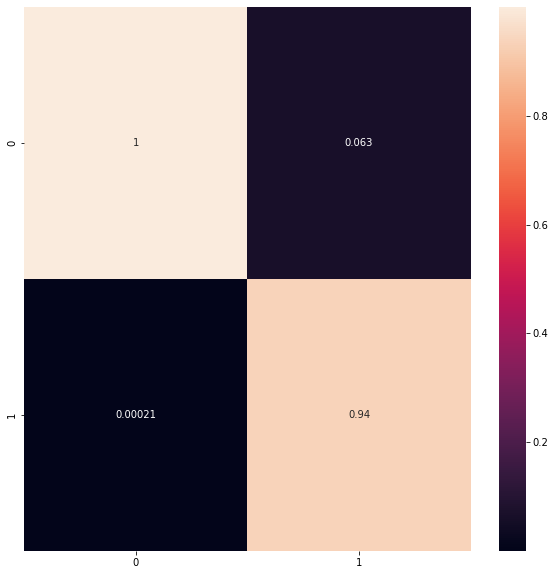

In [ ]:
plt.figure(figsize=(10, 10))

# Display the confusion matrix
import seaborn as sns
sns.heatmap(cm / np.sum(cm, axis=0), annot=True)

In [ ]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
plt.figure(figsize=(10, 10))

# Display the confusion matrix
ax = plt.gca()  # Get the current axes
disp = ConfusionMatrixDisplay.from_predictions(val_lab, y_pred, display_labels=('Not fraud', 'Fraud'), ax=ax, cmap='cividis')
plt.show()

NameError: ignored

In [ ]:
model.save('model_md_fnn_v3_0.h5')

In [ ]:
md = tf.keras.models.load_model('model_md_fnn_v2_2.h5')

In [ ]:
import time
start = time.time()
_ = md.predict(X)
end = time.time()
print(end - start)

 2782/30000 [=>............................] - ETA: 33s

KeyboardInterrupt: ignored

In [ ]:
36 / 30000

0.0012

In [ ]:
_ = md.predict(X)

15/15 [==============================] - 0s 2ms/step


In [ ]:
Тут ми маємо всього 129024 

<Axes: >

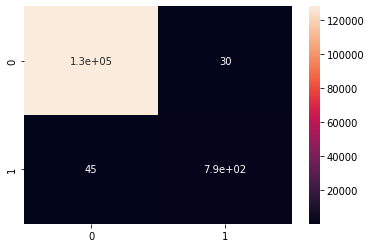

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True)